## Work
請結合前面的知識與程式碼，比較不同的 regularization 的組合對訓練的結果與影響：如 dropout, regularizers, batch-normalization 等

In [1]:
import os
import keras
import itertools

# Disable GPU
#os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
# ref: Day87
import pandas as pd

# params = {'k1': k1_values, 'k2': k2_values, ...}
# list multi-dimension parameter comnbinations
def to_params_dataframe_list(params):
    df_list = []
    for (i, (key, values)) in enumerate(params.items()):
        if len(values) == 0:
            raise ValueError('not support empty collection')
        if type(values[0]) == dict:
            df_list.append(pd.DataFrame(conv_LD_to_DL(values)))
        else:
            df_list.append(pd.DataFrame({key: values}))
    
    return df_combinations(df_list)    
    
def df_combinations(df_list):
    df_merged = df_list[0].copy()
    for df in df_list[1:]:
        df_merged = df_merged.assign(tmp_key=1).merge(df.assign(tmp_key=1)).drop('tmp_key', 1)
    return df_merged

# in : [{k1:v11, k2:v12, ...}, {k1:v21, k2:v22, ...} ...]
# out: {k1: [v11, v12, ... (sorted unique values)], k2: [v21, v22, ...]}
def unique_by_keys(dicts_list):
    tmp_d = dict()
    for (i, dicts) in enumerate(dicts_list):
        keys = tmp_d.keys()
        for k in dicts.keys():
            if k not in keys:
                tmp_d[k] = set()
        for (k, v) in dicts.items():
            v_set = tmp_d[k]
            v_set.add(v)
    d = {}
    for k, v in tmp_d.items():
        d[k] = sorted(list(v))
        
    return d

# ref: https://stackoverflow.com/questions/5558418/list-of-dicts-to-from-dict-of-lists
# DL: dict of lists {k1:[v11, v12, ...], k2:[v21, v22, ...]}
# LD: list of dicts [{k1:v11, k2:v12, ...}, {k1:v21, k2:v22, ...}]
def conv_LD_to_DL(LD):
    return {k: [dic[k] for dic in LD] for k in LD[0]}
def conv_DL_to_LD(DL):
    return [dict(zip(DL,t)) for t in zip(*DL.values())]

In [3]:
# ref: Day87
import numpy as np
def to_int(bool_val):
    return int(bool_val == 'true')

def to_val(val):
    if type(val) == np.bool_:
        return str(val.astype(int))
    elif type(val) == bool:
        return str(to_int(val))
    else:
        return str(val)

def to_rowkey(cols=[]):
    cols = cols
    def inner(row):
        s = ' '.join([f'{col}:{to_val(row[col])}' for col in cols])
        return f"{s}"
    return inner

def to_plot_legend(cols=[], cols_abbr={}):
    cols = cols
    cols_abbr = dict(zip(cols, cols)) if not cols_abbr else cols_abbr
    def inner(row):
        s = '_'.join([f'{cols_abbr[col]}:{to_val(row[col])}' for col in cols])
        return f'{s}'
    return inner

In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
# Hint 1 : 在 Dense 層中增加 Regularizers
# Hint 2 : 增加 Dropout 層並設定 dropout ratio 
# Hint 3 : 增加 Batch-normalization 層
from keras.layers import Dense, BatchNormalization, Activation, Dropout
from keras import regularizers

# Day_081: regularizer_type, Day_082: drp_ratio, Day_083: norm_type
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128],
              regularizer_type='', reg_params={},
              drp_ratio=0.2, 
              norm_type=''):
    input_layer = keras.layers.Input(input_shape)
    
    x = input_layer
    if norm_type == 'input':
        x = BatchNormalization()(x)

    if regularizer_type == 'l1':
        l1 = reg_params['l1']
        regularizer = regularizers.l1(l1)
    elif regularizer_type == 'l2':
        l2 = reg_params['l2']
        regularizer = regularizers.l2(l2)
    elif regularizer_type == 'l1_l2':
        l1 = reg_params['l1']
        l2 = reg_params['l2']
        regularizer = regularizers.l1_l2(l1=l1, l2=l2)
    else:
        regularizer = regularizers.l1_l2(l1=0, l2=0)
        #return None

    for i, n_units in enumerate(num_neurons):
        if norm_type == 'before_act':
            x = Dense(units=n_units, 
                        name="hidden_layer"+str(i+1),
                        kernel_regularizer=regularizer)(x)
            x = BatchNormalization()(x)
            x = Activation('relu')(x)
            if drp_ratio != 0:
                x = Dropout(drp_ratio)(x)
        elif norm_type == 'after_act':
            x = Dense(units=n_units, 
                        activation="relu", 
                        name="hidden_layer"+str(i+1),
                        kernel_regularizer=regularizer)(x)
            if drp_ratio != 0:
                x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
        else:
            x = Dense(units=n_units, 
                        activation="relu", 
                        name="hidden_layer"+str(i+1),
                        kernel_regularizer=regularizer)(x)
            if drp_ratio != 0:
                x = Dropout(drp_ratio)(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
# ref: Day87
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 1024
MOMENTUM = 0.95

In [9]:
KEY_DROPOUT     = "dropout"
KEY_NORM_TYPE   = "norm_type"
KEY_REGULARIZER = "regularizer"
KEY_REG_TYPE    = "reg_type"
KEY_REG_L1      = "reg_L1"
KEY_REG_L2      = "reg_L2"
                   
KEY_EXT_PLOT_LEGEND = '$plot_legend$'
KEY_EXT_ROWKEY      = '$rowkey$'


REG_TYPE = KEY_REG_TYPE
REG_L1   = KEY_REG_L1
REG_L2   = KEY_REG_L2

# 測試參數
# Day_081
opts_regularizers = [
        {REG_TYPE: 'no',    REG_L1:0,     REG_L2:0},
        {REG_TYPE: 'l1',    REG_L1:1e-12, REG_L2:0},
        {REG_TYPE: 'l2',    REG_L1:0,     REG_L2:1e-12},
        {REG_TYPE: 'l1_l2', REG_L1:1e-12, REG_L2:1e-12},

        #{REG_TYPE: 'no'},
        #{REG_TYPE: 'l1',    REG_L1:1e-12},
        #{REG_TYPE: 'l2',    REG_L2:1e-12},
        #{REG_TYPE: 'l1_l2', REG_L1:1e-12, REG_L2:1e-12},
    ]

uniq_dict = unique_by_keys(opts_regularizers)
opts_reg_type = uniq_dict[REG_TYPE]
opts_reg_l1   = uniq_dict[REG_L1]
opts_reg_l2   = uniq_dict[REG_L2]

#opts_dropout_ratio = [0.0, 0.1, 0.25, 0.5, 0.75]
opts_dropout_ratio = [0.0, 0.1, 0.3]

#opts_norm_type = ['no', 'before_act', 'after_act', 'input']
opts_norm_type = ['no', 'after_act']

param_opts = {
    KEY_NORM_TYPE   : opts_norm_type,
    KEY_DROPOUT     : opts_dropout_ratio,
    KEY_REGULARIZER : opts_regularizers,
    #KEY_REG_TYPE    : opts_reg_type,
    #KEY_REG_L1      : opts_reg_l1,
    #KEY_REG_L2      : opts_reg_l2,
}

opts_abbr = {
    KEY_NORM_TYPE   : 'nm',
    KEY_DROPOUT     : 'dp',
    #KEY_REGULARIZER : 'rg',
    KEY_REG_TYPE    : "reg",
    KEY_REG_L1      : "l1",
    KEY_REG_L2      : "l2",
}

print(f"\ntest parameters:\n{'- '*30}\n{param_opts}")
 
df_opts = to_params_dataframe_list(param_opts)

print(f"\ntest runs: {len(df_opts)}\n{'=-'*30}\n{df_opts}")

# 新增欄位
raw_cols=[col for col in df_opts.columns.values]
#df_opts[KEY_EXT_ROWKEY]      = df_opts[raw_cols].apply(to_rowkey(raw_cols), axis=1)
df_opts[KEY_EXT_PLOT_LEGEND] = df_opts[raw_cols].apply(to_plot_legend(raw_cols, opts_abbr), axis=1)

print(f"\ndf_opts:\n{'=-'*30}\n{df_opts}")


test parameters:
- - - - - - - - - - - - - - - - - - - - - - - - - - - - - - 
{'norm_type': ['no', 'after_act'], 'dropout': [0.0, 0.1, 0.3], 'regularizer': [{'reg_type': 'no', 'reg_L1': 0, 'reg_L2': 0}, {'reg_type': 'l1', 'reg_L1': 1e-12, 'reg_L2': 0}, {'reg_type': 'l2', 'reg_L1': 0, 'reg_L2': 1e-12}, {'reg_type': 'l1_l2', 'reg_L1': 1e-12, 'reg_L2': 1e-12}]}

test runs: 24
=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-=-
    norm_type  dropout reg_type        reg_L1        reg_L2
0          no      0.0       no  0.000000e+00  0.000000e+00
1          no      0.0       l1  1.000000e-12  0.000000e+00
2          no      0.0       l2  0.000000e+00  1.000000e-12
3          no      0.0    l1_l2  1.000000e-12  1.000000e-12
4          no      0.1       no  0.000000e+00  0.000000e+00
5          no      0.1       l1  1.000000e-12  0.000000e+00
6          no      0.1       l2  0.000000e+00  1.000000e-12
7          no      0.1    l1_l2  1.000000e-12  1.000000e-12
8          no      0.3

In [10]:
# 載入 Callbacks
from keras.callbacks import EarlyStopping

def gen_callback(monitor="val_loss", patience=20):
    earlystop = EarlyStopping(
        monitor=monitor, 
        patience=patience, 
        verbose=1
    )
    return earlystop

In [11]:
results = {}

test_runs = df_opts.shape[0]
for idx, opts in df_opts.iterrows():
    keras.backend.clear_session() # 把舊的 Graph 清掉
    
    p_dropout    = opts[KEY_DROPOUT]
    p_norm_type  = opts[KEY_NORM_TYPE]
    p_reg_type   = opts[KEY_REG_TYPE]
    p_reg_L1     = opts[KEY_REG_L1] if p_reg_type in ['l1', 'l1_l2'] else 0
    p_reg_L2     = opts[KEY_REG_L2] if p_reg_type in ['l2', 'l1_l2'] else 0
    p_reg_params = {'l1':p_reg_L1, 'l2':p_reg_L2}

    model = build_mlp(input_shape=x_train.shape[1:], 
                      regularizer_type=p_reg_type, 
                      reg_params=p_reg_params,
                      drp_ratio=p_dropout,
                      norm_type=p_norm_type
                     )
    print()
    print('-'*60)
    print(f"Experiment with {idx+1}/{test_runs}: \n{opts}")
    print()
    print(model.summary())

    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    earlystop = gen_callback()
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[earlystop]
             )

    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]
    
    exp_name_tag = opts[KEY_EXT_PLOT_LEGEND]
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc,
                             'params': opts
                            }        

Instructions for updating:
Colocations handled automatically by placer.

------------------------------------------------------------
Experiment with 1/24: 
norm_type                                       no
dropout                                          0
reg_type                                        no
reg_L1                                           0
reg_L2                                           0
$plot_legend$    nm:no_dp:0.0_reg:no_l1:0.0_l2:0.0
Name: 0, dtype: object

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
___________________________________________________

50000/50000 [==============================] - 9s 190us/step - loss: 0.6353 - acc: 0.8069 - val_loss: 1.5674 - val_acc: 0.4945
Epoch 43/50
50000/50000 [==============================] - 10s 190us/step - loss: 0.6179 - acc: 0.8136 - val_loss: 1.5792 - val_acc: 0.4899
Epoch 00043: early stopping

------------------------------------------------------------
Experiment with 2/24: 
norm_type                                         no
dropout                                            0
reg_type                                          l1
reg_L1                                         1e-12
reg_L2                                             0
$plot_legend$    nm:no_dp:0.0_reg:l1_l1:1e-12_l2:0.0
Name: 1, dtype: object

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 13s 262us/step - loss: 2.1726 - acc: 0.2830 - val_loss: 2.0591 - val_acc: 0.3259
Epoch 2/50
50000/50000 [==============================] - 10s 199us/step - loss: 1.7275 - acc: 0.3981 - val_loss: 1.8167 - val_acc: 0.3804
Epoch 3/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.6090 - acc: 0.4388 - val_loss: 1.6915 - val_acc: 0.4048
Epoch 4/50
50000/50000 [==============================] - 10s 205us/step - loss: 1.5385 - acc: 0.4628 - val_loss: 1.6499 - val_acc: 0.4196
Epoch 5/50
50000/50000 [==============================] - 11s 211us/step - loss: 1.4856 - acc: 0.4802 - val_loss: 1.5967 - val_acc: 0.4377
Epoch 6/50
50000/50000 [==============================] - 10s 210us/step - loss: 1.4396 - acc: 0.4964 - val_loss: 1.5695 - val_acc: 0.4467
Epoch 7/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.3975 - acc: 0.5124 - val_loss: 1.

50000/50000 [==============================] - 9s 187us/step - loss: 1.6171 - acc: 0.4343 - val_loss: 1.7014 - val_acc: 0.4118
Epoch 4/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5444 - acc: 0.4609 - val_loss: 1.6325 - val_acc: 0.4354
Epoch 5/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.4889 - acc: 0.4798 - val_loss: 1.5909 - val_acc: 0.4424
Epoch 6/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.4432 - acc: 0.4957 - val_loss: 1.5677 - val_acc: 0.4494
Epoch 7/50
50000/50000 [==============================] - 11s 213us/step - loss: 1.4048 - acc: 0.5096 - val_loss: 1.5475 - val_acc: 0.4568
Epoch 8/50
50000/50000 [==============================] - 10s 191us/step - loss: 1.3705 - acc: 0.5230 - val_loss: 1.5242 - val_acc: 0.4657
Epoch 9/50
50000/50000 [==============================] - 10s 190us/step - loss: 1.3381 - acc: 0.5326 - val_loss: 1.5147 - val_acc: 0.4674
Epoch 10/50
50000/50000 [================

50000/50000 [==============================] - 10s 194us/step - loss: 1.7729 - acc: 0.3795 - val_loss: 1.6631 - val_acc: 0.4066s
Epoch 5/50
50000/50000 [==============================] - 10s 193us/step - loss: 1.7209 - acc: 0.3968 - val_loss: 1.6276 - val_acc: 0.4208
Epoch 6/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.6732 - acc: 0.4120 - val_loss: 1.5972 - val_acc: 0.4291
Epoch 7/50
50000/50000 [==============================] - 10s 190us/step - loss: 1.6411 - acc: 0.4203 - val_loss: 1.5889 - val_acc: 0.4307
Epoch 8/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.6107 - acc: 0.4310 - val_loss: 1.5424 - val_acc: 0.4530
Epoch 9/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.5847 - acc: 0.4395 - val_loss: 1.5263 - val_acc: 0.4607
Epoch 10/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.5642 - acc: 0.4438 - val_loss: 1.5371 - val_acc: 0.4591
Epoch 11/50
50000/50000 [===========

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 238us/step - loss: 2.4350 - acc: 0.2210 - val_loss: 2.0146 - val_acc: 0.3272
Epoch 2/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.9855 - acc: 0.3236 - val_loss: 1.7965 - val_acc: 0.3712
Epoch 3/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.8489 - acc: 0.3603 - val_loss: 1.7192 - val_acc: 0.3974
Epoch 4/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.7670 - acc: 0.3854 - val_loss: 1.6499 - val_acc: 0.4218
Epoch 5/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.7155 - acc: 0.3994 - val_loss: 1.6209 - val_acc: 0.4266
Epoch 6/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.6709 - acc: 0.4128 - val_loss: 1.5967 - val_acc: 0.4320
Epoch 7/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.6365 - acc: 0.4230 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 238us/step - loss: 2.4763 - acc: 0.2042 - val_loss: 2.0393 - val_acc: 0.2988
Epoch 2/50
50000/50000 [==============================] - 10s 197us/step - loss: 2.0154 - acc: 0.3104 - val_loss: 1.8065 - val_acc: 0.3628
Epoch 3/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.8769 - acc: 0.3471 - val_loss: 1.7349 - val_acc: 0.3814
Epoch 4/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.7999 - acc: 0.3705 - val_loss: 1.6830 - val_acc: 0.4058
Epoch 5/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.7419 - acc: 0.3886 - val_loss: 1.6382 - val_acc: 0.4174
Epoch 6/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.6920 - acc: 0.4021 - val_loss: 1.6167 - val_acc: 0.4292
Epoch 7/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.6611 - acc: 0.4141 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 242us/step - loss: 2.4687 - acc: 0.2130 - val_loss: 2.0559 - val_acc: 0.3136
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.0328 - acc: 0.3104 - val_loss: 1.8477 - val_acc: 0.3624
Epoch 3/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.8897 - acc: 0.3487 - val_loss: 1.7259 - val_acc: 0.3989
Epoch 4/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.8073 - acc: 0.3691 - val_loss: 1.6768 - val_acc: 0.4053
Epoch 5/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.7468 - acc: 0.3906 - val_loss: 1.6546 - val_acc: 0.4207
Epoch 6/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.6990 - acc: 0.4036 - val_loss: 1.6200 - val_acc: 0.4292
Epoch 7/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.6675 - acc: 0.4140 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 226us/step - loss: 2.6958 - acc: 0.1584 - val_loss: 2.0267 - val_acc: 0.2851
Epoch 2/50
50000/50000 [==============================] - 9s 188us/step - loss: 2.3367 - acc: 0.2321 - val_loss: 1.8767 - val_acc: 0.3328
Epoch 3/50
50000/50000 [==============================] - 9s 189us/step - loss: 2.1817 - acc: 0.2614 - val_loss: 1.8007 - val_acc: 0.3576
Epoch 4/50
50000/50000 [==============================] - 9s 186us/step - loss: 2.0832 - acc: 0.2860 - val_loss: 1.7849 - val_acc: 0.3582
Epoch 5/50
50000/50000 [==============================] - 9s 186us/step - loss: 2.0168 - acc: 0.3019 - val_loss: 1.7438 - val_acc: 0.3720
Epoch 6/50
50000/50000 [==============================] - 9s 188us/step - loss: 1.9593 - acc: 0.3154 - val_loss: 1.7022 - val_acc: 0.3932
Epoch 7/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.9094 - acc: 0.3257 - val_loss: 1.6857 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 237us/step - loss: 2.6302 - acc: 0.1639 - val_loss: 2.0264 - val_acc: 0.2846
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.2907 - acc: 0.2348 - val_loss: 1.8879 - val_acc: 0.3305
Epoch 3/50
50000/50000 [==============================] - 10s 195us/step - loss: 2.1433 - acc: 0.2708 - val_loss: 1.8453 - val_acc: 0.3453
Epoch 4/50
50000/50000 [==============================] - 10s 201us/step - loss: 2.0538 - acc: 0.2915 - val_loss: 1.8099 - val_acc: 0.3515
Epoch 5/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.9932 - acc: 0.3022 - val_loss: 1.7695 - val_acc: 0.3728
Epoch 6/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.9449 - acc: 0.3165 - val_loss: 1.7210 - val_acc: 0.3850
Epoch 7/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.9007 - acc: 0.3311 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 236us/step - loss: 2.7145 - acc: 0.1531 - val_loss: 2.0326 - val_acc: 0.2879
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.3433 - acc: 0.2252 - val_loss: 1.8850 - val_acc: 0.3325
Epoch 3/50
50000/50000 [==============================] - 10s 194us/step - loss: 2.1686 - acc: 0.2616 - val_loss: 1.8179 - val_acc: 0.3586
Epoch 4/50
50000/50000 [==============================] - 10s 195us/step - loss: 2.0789 - acc: 0.2863 - val_loss: 1.7667 - val_acc: 0.3789
Epoch 5/50
50000/50000 [==============================] - 10s 195us/step - loss: 2.0208 - acc: 0.2998 - val_loss: 1.7511 - val_acc: 0.3744
Epoch 6/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.9545 - acc: 0.3158 - val_loss: 1.7043 - val_acc: 0.3909
Epoch 7/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.9177 - acc: 0.3251 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 240us/step - loss: 2.6949 - acc: 0.1544 - val_loss: 1.9983 - val_acc: 0.2912
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.3194 - acc: 0.2304 - val_loss: 1.8811 - val_acc: 0.3226
Epoch 3/50
50000/50000 [==============================] - 10s 197us/step - loss: 2.1638 - acc: 0.2656 - val_loss: 1.8136 - val_acc: 0.3562
Epoch 4/50
50000/50000 [==============================] - 10s 195us/step - loss: 2.0681 - acc: 0.2873 - val_loss: 1.7865 - val_acc: 0.3616
Epoch 5/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.9972 - acc: 0.3033 - val_loss: 1.7536 - val_acc: 0.3719
Epoch 6/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.9495 - acc: 0.3169 - val_loss: 1.7263 - val_acc: 0.3846
Epoch 7/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.9095 - acc: 0.3238 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 10s 208us/step - loss: 2.1712 - acc: 0.2777 - val_loss: 2.0458 - val_acc: 0.3249
Epoch 2/50
50000/50000 [==============================] - 9s 173us/step - loss: 1.7356 - acc: 0.3939 - val_loss: 1.7596 - val_acc: 0.3878
Epoch 3/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.6150 - acc: 0.4320 - val_loss: 1.6680 - val_acc: 0.4139
Epoch 4/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.5453 - acc: 0.4582 - val_loss: 1.6266 - val_acc: 0.4269
Epoch 5/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4919 - acc: 0.4785 - val_loss: 1.5923 - val_acc: 0.4484
Epoch 6/50
50000/50000 [==============================] - 9s 174us/step - loss: 1.4471 - acc: 0.4945 - val_loss: 1.5581 - val_acc: 0.4543
Epoch 7/50
50000/50000 [==============================] - 9s 175us/step - loss: 1.4084 - acc: 0.5093 - val_loss: 1.5445 -

50000/50000 [==============================] - 9s 184us/step - loss: 1.6225 - acc: 0.4306 - val_loss: 1.6908 - val_acc: 0.4050
Epoch 4/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.5489 - acc: 0.4578 - val_loss: 1.6306 - val_acc: 0.4269
Epoch 5/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.4918 - acc: 0.4778 - val_loss: 1.6062 - val_acc: 0.4306
Epoch 6/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.4455 - acc: 0.4938 - val_loss: 1.5732 - val_acc: 0.4401
Epoch 7/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.4043 - acc: 0.5081 - val_loss: 1.5435 - val_acc: 0.4597
Epoch 8/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.3696 - acc: 0.5224 - val_loss: 1.5282 - val_acc: 0.4632
Epoch 9/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.3349 - acc: 0.5350 - val_loss: 1.5174 - val_acc: 0.4668
Epoch 10/50
50000/50000 [====================

50000/50000 [==============================] - 9s 182us/step - loss: 1.2975 - acc: 0.5469 - val_loss: 1.5067 - val_acc: 0.4667
Epoch 11/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.2707 - acc: 0.5596 - val_loss: 1.4895 - val_acc: 0.4762
Epoch 12/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.2432 - acc: 0.5679 - val_loss: 1.4786 - val_acc: 0.4802
Epoch 13/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.2176 - acc: 0.5784 - val_loss: 1.4713 - val_acc: 0.4821
Epoch 14/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.1932 - acc: 0.5882 - val_loss: 1.4647 - val_acc: 0.4846
Epoch 15/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.1703 - acc: 0.5967 - val_loss: 1.4668 - val_acc: 0.4782
Epoch 16/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.1466 - acc: 0.6067 - val_loss: 1.4518 - val_acc: 0.4952
Epoch 17/50
50000/50000 [==============

Epoch 9/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.3337 - acc: 0.5365 - val_loss: 1.5274 - val_acc: 0.4612
Epoch 10/50
50000/50000 [==============================] - 9s 189us/step - loss: 1.3032 - acc: 0.5474 - val_loss: 1.5104 - val_acc: 0.4684
Epoch 11/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.2744 - acc: 0.5570 - val_loss: 1.5050 - val_acc: 0.4734
Epoch 12/50
50000/50000 [==============================] - 9s 184us/step - loss: 1.2473 - acc: 0.5679 - val_loss: 1.4764 - val_acc: 0.4788
Epoch 13/50
50000/50000 [==============================] - 9s 182us/step - loss: 1.2205 - acc: 0.5769 - val_loss: 1.4687 - val_acc: 0.4858
Epoch 14/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.1947 - acc: 0.5872 - val_loss: 1.4838 - val_acc: 0.4786
Epoch 15/50
50000/50000 [==============================] - 9s 183us/step - loss: 1.1728 - acc: 0.5964 - val_loss: 1.4690 - val_acc: 0.4819
Epoch 16/50
50000/50000 [===

50000/50000 [==============================] - 9s 185us/step - loss: 1.5960 - acc: 0.4340 - val_loss: 1.5508 - val_acc: 0.4482
Epoch 10/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5701 - acc: 0.4440 - val_loss: 1.5355 - val_acc: 0.4533
Epoch 11/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5472 - acc: 0.4499 - val_loss: 1.5172 - val_acc: 0.4595
Epoch 12/50
50000/50000 [==============================] - 9s 185us/step - loss: 1.5292 - acc: 0.4567 - val_loss: 1.4983 - val_acc: 0.4692
Epoch 13/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.5127 - acc: 0.4615 - val_loss: 1.4851 - val_acc: 0.4750
Epoch 14/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.4925 - acc: 0.4687 - val_loss: 1.4922 - val_acc: 0.4682
Epoch 15/50
50000/50000 [==============================] - 9s 186us/step - loss: 1.4791 - acc: 0.4736 - val_loss: 1.4688 - val_acc: 0.4761
Epoch 16/50
50000/50000 [==============

50000/50000 [==============================] - 12s 236us/step - loss: 2.4438 - acc: 0.2122 - val_loss: 2.0382 - val_acc: 0.3074
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.0005 - acc: 0.3152 - val_loss: 1.7999 - val_acc: 0.3668
Epoch 3/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.8644 - acc: 0.3512 - val_loss: 1.7397 - val_acc: 0.3907
Epoch 4/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.7885 - acc: 0.3735 - val_loss: 1.6580 - val_acc: 0.4125
Epoch 5/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.7412 - acc: 0.3874 - val_loss: 1.6299 - val_acc: 0.4235
Epoch 6/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.6877 - acc: 0.4017 - val_loss: 1.6116 - val_acc: 0.4247
Epoch 7/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.6493 - acc: 0.4142 - val_loss: 1.5730 - val_acc: 0.4378
Epoch 8/50
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 238us/step - loss: 2.4265 - acc: 0.2197 - val_loss: 2.0742 - val_acc: 0.3058
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.9927 - acc: 0.3176 - val_loss: 1.7982 - val_acc: 0.3734
Epoch 3/50
50000/50000 [==============================] - 10s 197us/step - loss: 1.8600 - acc: 0.3505 - val_loss: 1.7280 - val_acc: 0.3882
Epoch 4/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.7768 - acc: 0.3772 - val_loss: 1.6705 - val_acc: 0.4073
Epoch 5/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.7233 - acc: 0.3941 - val_loss: 1.6405 - val_acc: 0.4126
Epoch 6/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.6803 - acc: 0.4080 - val_loss: 1.6031 - val_acc: 0.4269
Epoch 7/50
50000/50000 [==============================] - 10s 194us/step - loss: 1.6462 - acc: 0.4208 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 241us/step - loss: 2.4394 - acc: 0.2078 - val_loss: 2.0330 - val_acc: 0.3098
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.0108 - acc: 0.3149 - val_loss: 1.8255 - val_acc: 0.3704
Epoch 3/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.8694 - acc: 0.3515 - val_loss: 1.7217 - val_acc: 0.3917
Epoch 4/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.7919 - acc: 0.3726 - val_loss: 1.6558 - val_acc: 0.4195
Epoch 5/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.7363 - acc: 0.3898 - val_loss: 1.6276 - val_acc: 0.4248
Epoch 6/50
50000/50000 [==============================] - 10s 198us/step - loss: 1.6929 - acc: 0.4046 - val_loss: 1.6025 - val_acc: 0.4300
Epoch 7/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.6526 - acc: 0.4150 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 11s 225us/step - loss: 2.7090 - acc: 0.1573 - val_loss: 2.0305 - val_acc: 0.2835
Epoch 2/50
50000/50000 [==============================] - 9s 187us/step - loss: 2.3100 - acc: 0.2390 - val_loss: 1.8489 - val_acc: 0.3430
Epoch 3/50
50000/50000 [==============================] - 9s 187us/step - loss: 2.1543 - acc: 0.2713 - val_loss: 1.7956 - val_acc: 0.3598
Epoch 4/50
50000/50000 [==============================] - 9s 187us/step - loss: 2.0654 - acc: 0.2848 - val_loss: 1.7631 - val_acc: 0.3698
Epoch 5/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.9937 - acc: 0.3026 - val_loss: 1.7329 - val_acc: 0.3762
Epoch 6/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.9418 - acc: 0.3170 - val_loss: 1.6962 - val_acc: 0.3928
Epoch 7/50
50000/50000 [==============================] - 9s 187us/step - loss: 1.8951 - acc: 0.3300 - val_loss: 1.6855 -

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 238us/step - loss: 2.6931 - acc: 0.1494 - val_loss: 2.0462 - val_acc: 0.2580
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.3239 - acc: 0.2285 - val_loss: 1.8927 - val_acc: 0.3328
Epoch 3/50
50000/50000 [==============================] - 10s 197us/step - loss: 2.1603 - acc: 0.2643 - val_loss: 1.8332 - val_acc: 0.3536
Epoch 4/50
50000/50000 [==============================] - 10s 195us/step - loss: 2.0731 - acc: 0.2841 - val_loss: 1.7774 - val_acc: 0.3717
Epoch 5/50
50000/50000 [==============================] - 10s 194us/step - loss: 2.0034 - acc: 0.3022 - val_loss: 1.7640 - val_acc: 0.37146 - acc:  - ETA: 3s - loss: 2.0213 - ETA: 1s - loss: 2.0080 - acc:
Epoch 6/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.9498 - acc: 0.3161 - val_loss: 1.7280 - val_acc: 0.3841
Epoch 7/50
50000/50000 [==========================

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 238us/step - loss: 2.6992 - acc: 0.1512 - val_loss: 2.0052 - val_acc: 0.2862
Epoch 2/50
50000/50000 [==============================] - 10s 195us/step - loss: 2.3294 - acc: 0.2311 - val_loss: 1.8668 - val_acc: 0.3306
Epoch 3/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.1670 - acc: 0.2613 - val_loss: 1.8288 - val_acc: 0.3489
Epoch 4/50
50000/50000 [==============================] - 10s 194us/step - loss: 2.0695 - acc: 0.2863 - val_loss: 1.8015 - val_acc: 0.3630
Epoch 5/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.9966 - acc: 0.3037 - val_loss: 1.7218 - val_acc: 0.3905
Epoch 6/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.9475 - acc: 0.3165 - val_loss: 1.6995 - val_acc: 0.3949
Epoch 7/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.9138 - acc: 0.3226 - val_loss: 1.

Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 12s 241us/step - loss: 2.6770 - acc: 0.1651 - val_loss: 2.0669 - val_acc: 0.2585
Epoch 2/50
50000/50000 [==============================] - 10s 196us/step - loss: 2.3127 - acc: 0.2351 - val_loss: 1.9145 - val_acc: 0.3176
Epoch 3/50
50000/50000 [==============================] - 10s 197us/step - loss: 2.1615 - acc: 0.2659 - val_loss: 1.8249 - val_acc: 0.3490
Epoch 4/50
50000/50000 [==============================] - 10s 195us/step - loss: 2.0602 - acc: 0.2905 - val_loss: 1.7705 - val_acc: 0.3668
Epoch 5/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.9984 - acc: 0.3011 - val_loss: 1.7395 - val_acc: 0.3791
Epoch 6/50
50000/50000 [==============================] - 10s 195us/step - loss: 1.9514 - acc: 0.3144 - val_loss: 1.7200 - val_acc: 0.3825
Epoch 7/50
50000/50000 [==============================] - 10s 196us/step - loss: 1.9101 - acc: 0.3282 - val_loss: 1.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_data_1(results, title=''):
    print(f"code map:{opts_abbr}")
    
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True)
    fig.set_size_inches(24, 8)
    #plt.subplots_adjust(bottom=.05, top=.9, hspace=.9)

    fig.suptitle(title)

    for i, cond in enumerate(results.keys()):
        legend_label = cond
        ax1.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-',  label=legend_label+'_t', color=color_bar[i])
        ax1.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label+'_v', color=color_bar[i])
    ax1.set_title("Loss")
    ax1.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')

    for i, cond in enumerate(results.keys()):
        legend_label = cond
        ax2.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=legend_label+'_t', color=color_bar[i])
        ax2.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label+'_v', color=color_bar[i])
    ax2.set_title("Accuracy")
    ax2.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax2.set_ylabel('Accuracy')
    ax2.set_xlabel('Epoch')
   
    plt.show()
    
def plot_data_2(results, title=''):
    print(f"code map:{opts_abbr}")
    plt.clf()
    
    NUM_COLORS = len(results.keys())
    cm = plt.get_cmap('gist_rainbow')
    color_bar = [cm(1.*i/NUM_COLORS) for i in range(NUM_COLORS)]
    
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-',  label=legend_label+'_t', color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=legend_label+'_v', color=color_bar[i])
    plt.title(f"Loss {title}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.show()

    plt.clf()
    for i, cond in enumerate(results.keys()):
        legend_label = cond
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-',  label=legend_label+'_t', color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=legend_label+'_v', color=color_bar[i])
    plt.title(f"Accuracy {title}")
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.show()
    
    print('='*80)
    print()   
    
    
plot_data = plot_data_2 

code map:{'norm_type': 'nm', 'dropout': 'dp', 'reg_type': 'reg', 'reg_L1': 'l1', 'reg_L2': 'l2'}


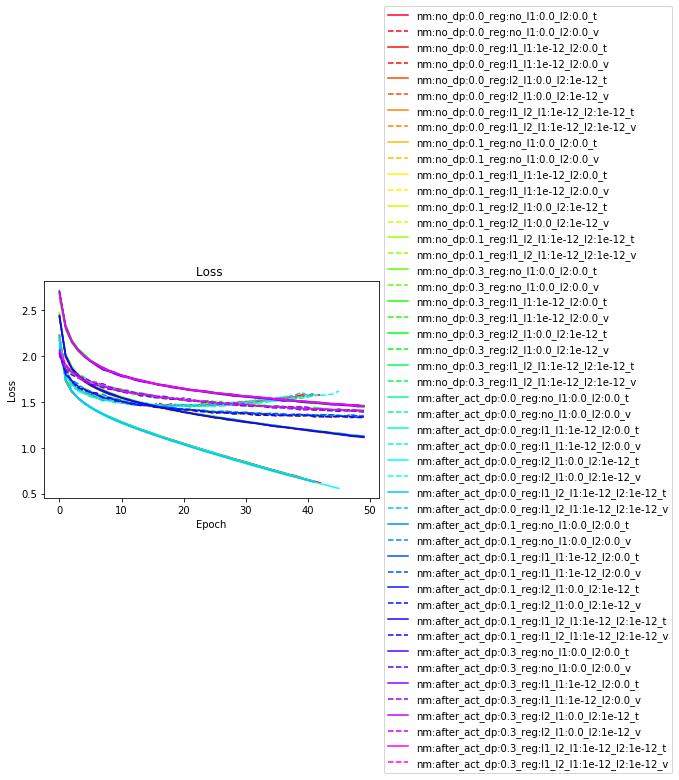

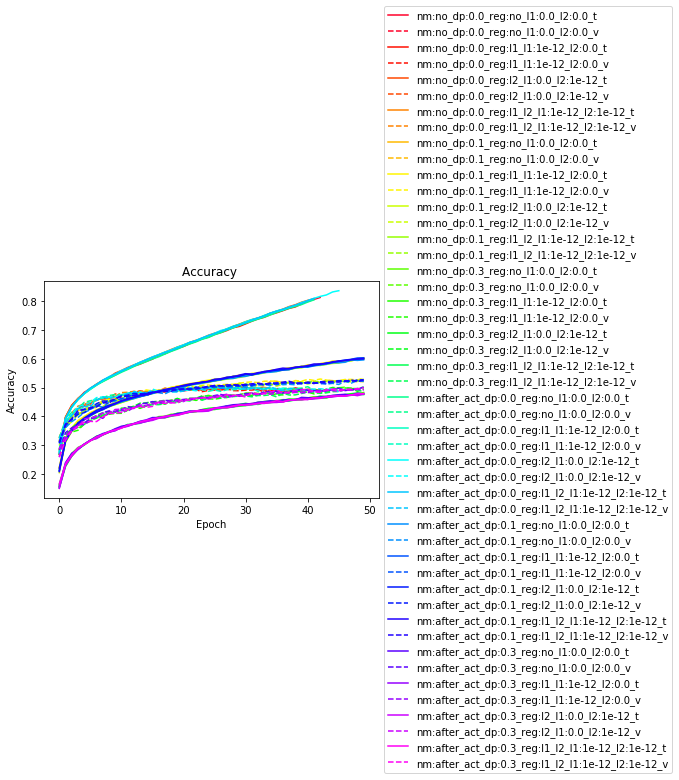

In [13]:
plot_data(results)

code map:{'norm_type': 'nm', 'dropout': 'dp', 'reg_type': 'reg', 'reg_L1': 'l1', 'reg_L2': 'l2'}


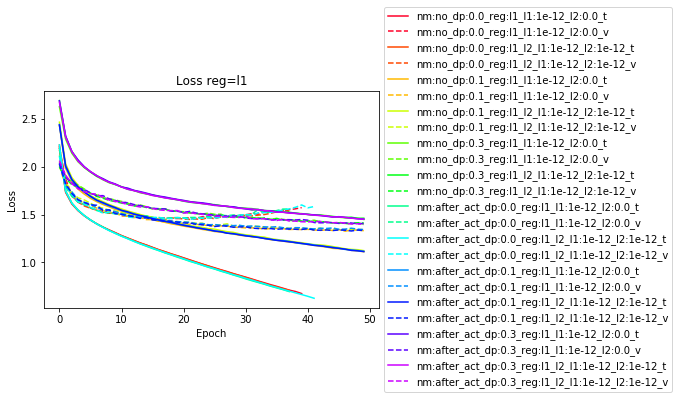

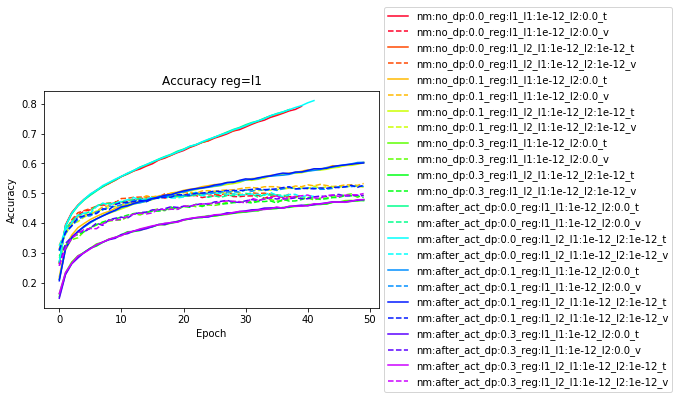


code map:{'norm_type': 'nm', 'dropout': 'dp', 'reg_type': 'reg', 'reg_L1': 'l1', 'reg_L2': 'l2'}


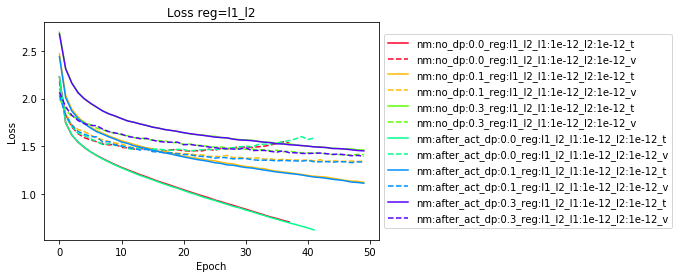

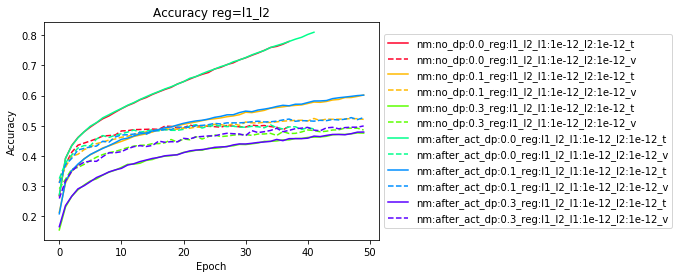


code map:{'norm_type': 'nm', 'dropout': 'dp', 'reg_type': 'reg', 'reg_L1': 'l1', 'reg_L2': 'l2'}


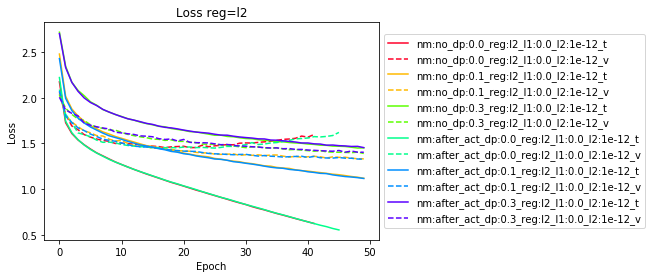

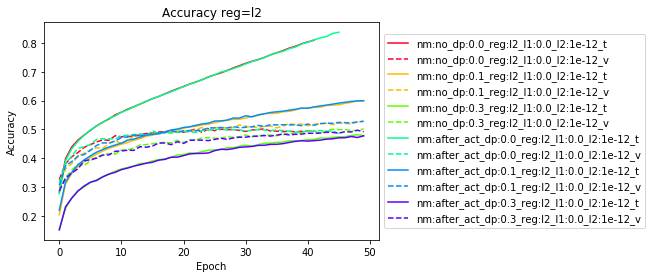


code map:{'norm_type': 'nm', 'dropout': 'dp', 'reg_type': 'reg', 'reg_L1': 'l1', 'reg_L2': 'l2'}


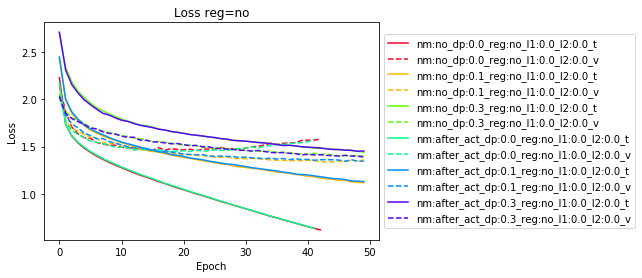

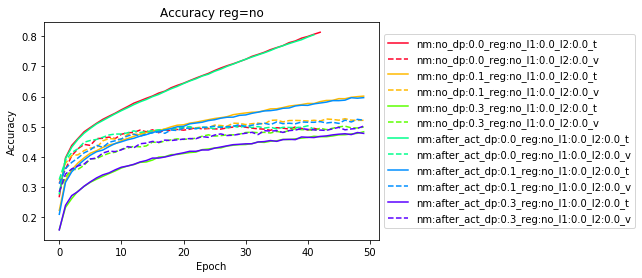

In [14]:
# Day_081
for reg_type in opts_reg_type:
    results_by_key = {k: v for k, v in results.items() if f'{opts_abbr[KEY_REG_TYPE]}:{reg_type}' in k}
    plot_data(results_by_key, title=f'{opts_abbr[KEY_REG_TYPE]}={reg_type}')

code map:{'norm_type': 'nm', 'dropout': 'dp', 'reg_type': 'reg', 'reg_L1': 'l1', 'reg_L2': 'l2'}


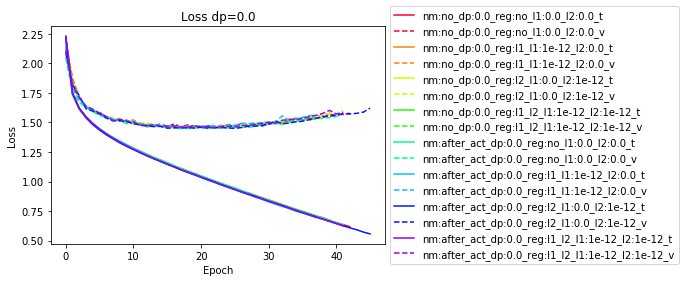

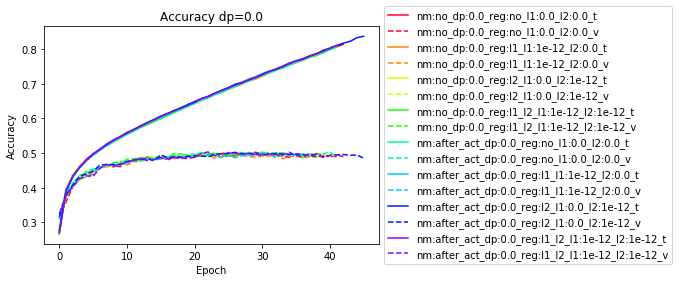


code map:{'norm_type': 'nm', 'dropout': 'dp', 'reg_type': 'reg', 'reg_L1': 'l1', 'reg_L2': 'l2'}


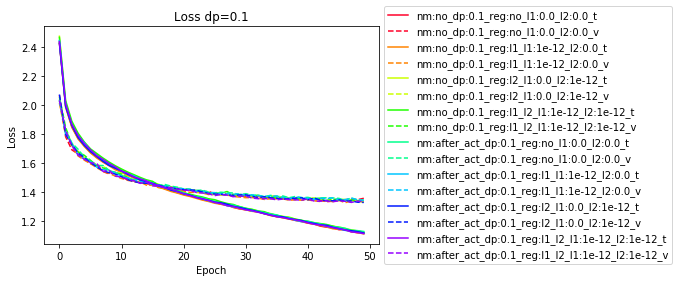

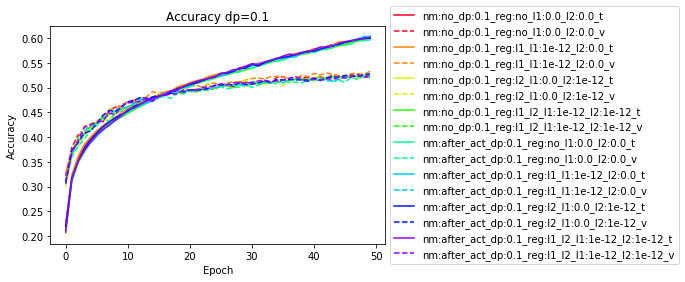


code map:{'norm_type': 'nm', 'dropout': 'dp', 'reg_type': 'reg', 'reg_L1': 'l1', 'reg_L2': 'l2'}


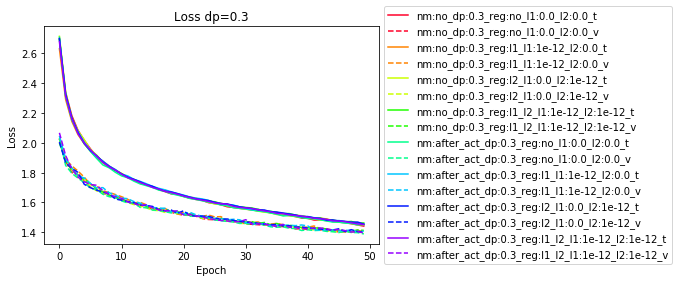

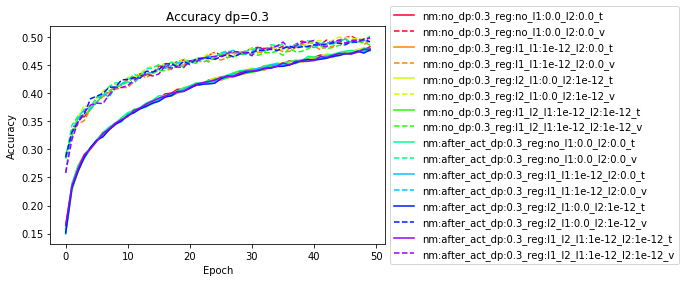

In [15]:
# Day_082
for droupout in opts_dropout_ratio:
    results_by_key = {k: v for k, v in results.items() if f'{opts_abbr[KEY_DROPOUT]}:{droupout}' in k}
    plot_data(results_by_key, title=f'{opts_abbr[KEY_DROPOUT]}={droupout}')

code map:{'norm_type': 'nm', 'dropout': 'dp', 'reg_type': 'reg', 'reg_L1': 'l1', 'reg_L2': 'l2'}


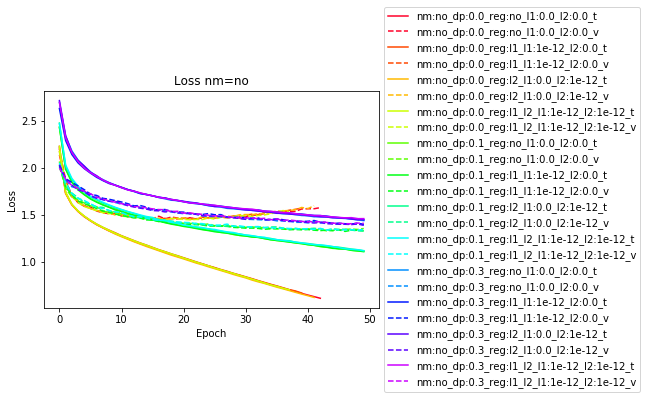

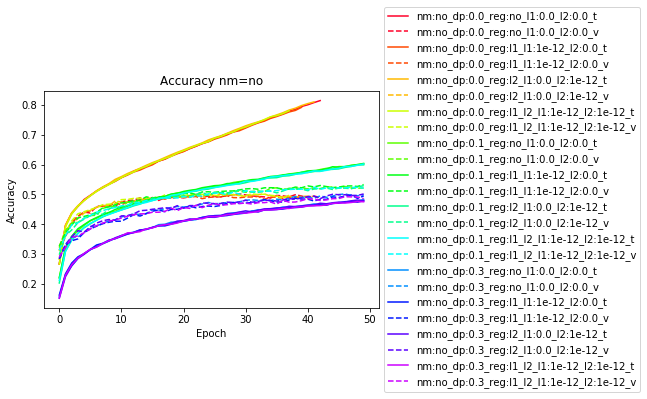


code map:{'norm_type': 'nm', 'dropout': 'dp', 'reg_type': 'reg', 'reg_L1': 'l1', 'reg_L2': 'l2'}


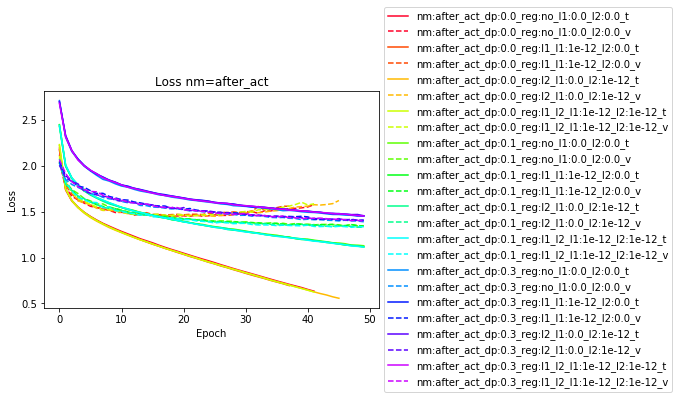

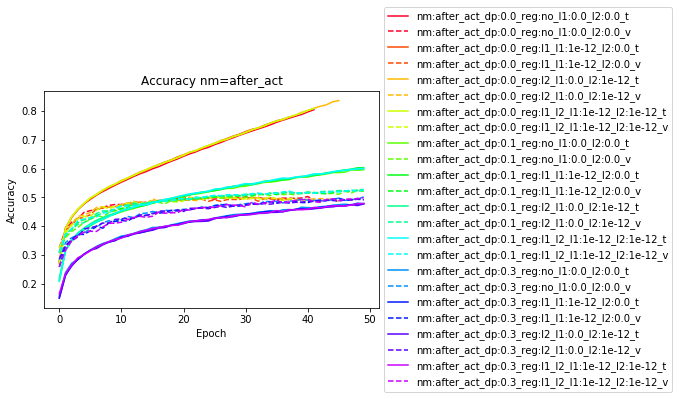

In [16]:
# Day_083
for norm_type in opts_norm_type:
    results_by_key = {k: v for k, v in results.items() if f'{opts_abbr[KEY_NORM_TYPE]}:{norm_type}' in k}
    plot_data(results_by_key, title=f'{opts_abbr[KEY_NORM_TYPE]}={norm_type}')